In [227]:
#expr_nose <- read.csv("nose_cluster_averages55.csv")
#expr_jaw  <- read.csv("jaw_cluster_averages55.csv")
# Rename the first column to "gene"
#colnames(expr_nose)[1] <- "gene"
#colnames(expr_jaw)[1]  <- "gene"
# Rename columns to include region identifier, except for the gene column
#colnames(expr_nose)[-1] <- paste0(colnames(expr_nose)[-1], "_nose")
#colnames(expr_jaw)[-1]  <- paste0(colnames(expr_jaw)[-1],  "_jaw")
# Merge on gene identifier
#merged_expr <- merge(expr_nose, expr_jaw, by = "gene")
#write.csv(merged_expr, "nose_jaw_cluster_avg55.csv", row.names = FALSE)
#colnames(white)[1] <- "gene"
#white[nrow(white) + 1, ] <- NA        # Add new empty row
#white$gene[nrow(white)] <- "DENND1B"  # Set gene name in new row

In [228]:
genes_df <- read.csv("genes_df_hg38_filtered.csv")

In [229]:
snps_df <- read.csv("white_SNPs_filtered_nose_jaw_scores_hg38.csv")

In [230]:
colnames(snps_df)[3] <- "snp"

In [231]:
library(GenomicRanges)

In [232]:
snps_df <- snps_df[!grepl("^NA_NA_", snps_df$snp), ]

# Example input format:
# genes_df: chr, start, end, gene
# snps_df: snp (e.g., "1_2545345_rs123"), snp_jaw_nose_score

# First, parse SNP positions clearly:
snps_df$chr <- sapply(strsplit(snps_df$snp, "_"), `[`, 1)
snps_df$pos <- as.numeric(sapply(strsplit(snps_df$snp, "_"), `[`, 2))

# fix chromosome names


In [233]:
genes_df$seqnames <- gsub("^CHR", "", genes_df$seqnames)

# For genes_df (assumes chr as character, e.g., "1", "2", ... "22", "X", "Y")
genes_df <- genes_df[genes_df$seqnames %in% as.character(1:22), ]

# For snps_df
snps_df <- snps_df[snps_df$chr %in% as.character(1:22), ]


In [234]:

# Convert genes and SNPs to GenomicRanges objects
gene_gr <- GRanges(
  seqnames = genes_df$seqnames,
  ranges = IRanges(start = genes_df$start - 5000, end = genes_df$end + 5000),
  gene = genes_df$SYMBOL
)

snp_gr <- GRanges(
  seqnames = snps_df$chr,
  ranges = IRanges(start = snps_df$pos, end = snps_df$pos),
  snp_score = snps_df$nose_jaw_diff_logp_geom
)



In [1]:
#gene_gr

In [2]:
#snp_gr

In [237]:
# Aggregate scores per gene
library(dplyr)



overlaps <- findOverlaps(gene_gr, snp_gr)

overlap_df <- data.frame(
  gene = gene_gr$gene[queryHits(overlaps)],
  snp_score = snp_gr$snp_score[subjectHits(overlaps)]
)


In [238]:
colnames(genes_df)[colnames(genes_df) == "SYMBOL"] <- "gene"

In [239]:
# Calculate mean SNP jaw-nose score per gene:
gene_snp_scores <- overlap_df %>%
  group_by(gene) %>%
  summarise(mean_snp_jaw_nose_score = mean(snp_score, na.rm = TRUE))

# Add scores back to genes_df
genes_df <- left_join(genes_df, gene_snp_scores, by = "gene")

In [240]:
genes_df <- genes_df[!is.na(genes_df$mean_snp_jaw_nose_score), ]

In [241]:
genes_df <- genes_df[order(-genes_df$mean_snp_jaw_nose_score), ]

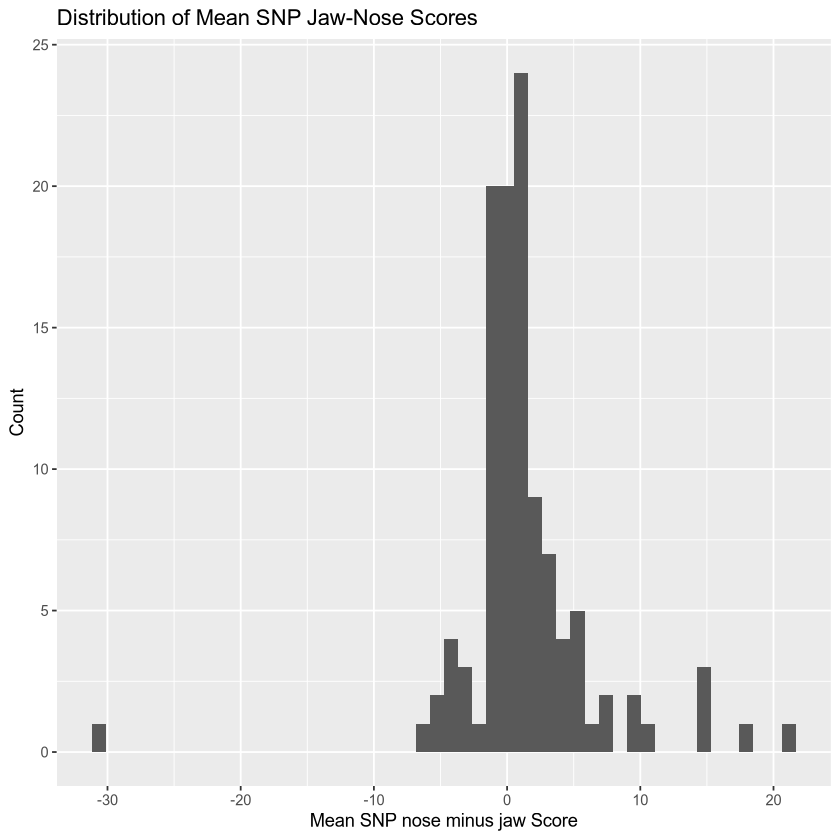

In [242]:
library(ggplot2)
ggplot(genes_df, aes(x = mean_snp_jaw_nose_score)) +
  geom_histogram(bins = 50) +
  labs(title = "Distribution of Mean SNP Jaw-Nose Scores",
       x = "Mean SNP nose minus jaw Score",
       y = "Count")


In [243]:
write.csv(genes_df, "genes_with_SNP_score_5k.csv", row.names = FALSE)

In [5]:
# IMPORTANT
#### GO BACK AND REPEAT THESE STEPS FOR 50K and 500K ####
#

In [244]:
# Read in your per-window result files
scores_5k   <- read.csv("genes_with_SNP_score_5k.csv")
scores_50k  <- read.csv("genes_with_SNP_score_50k.csv")
scores_500k <- read.csv("genes_with_SNP_score_500k.csv")

# Rename score columns to reflect window
colnames(scores_5k)[colnames(scores_5k) == "mean_snp_jaw_nose_score"] <- "score_5k"
colnames(scores_50k)[colnames(scores_50k) == "mean_snp_jaw_nose_score"] <- "score_50k"
colnames(scores_500k)[colnames(scores_500k) == "mean_snp_jaw_nose_score"] <- "score_500k"

# Merge these into your main genes_df by gene symbol
genes_df <- Reduce(function(x, y) merge(x, y, by = "gene", all.x = TRUE),
                   list(genes_df, scores_5k[, c("gene", "score_5k")], 
                        scores_50k[, c("gene", "score_50k")], 
                        scores_500k[, c("gene", "score_500k")]))


In [245]:
write.csv(genes_df, "genes_with_SNP_scores_all.csv", row.names = FALSE)

In [246]:
# Read in your window result files (as before)
scores_5k   <- read.csv("genes_with_SNP_score_5k.csv")
scores_50k  <- read.csv("genes_with_SNP_score_50k.csv")
scores_500k <- read.csv("genes_with_SNP_score_500k.csv")

# Rename score columns
colnames(scores_5k)[colnames(scores_5k) == "mean_snp_jaw_nose_score"] <- "score_5k"
colnames(scores_50k)[colnames(scores_50k) == "mean_snp_jaw_nose_score"] <- "score_50k"
colnames(scores_500k)[colnames(scores_500k) == "mean_snp_jaw_nose_score"] <- "score_500k"

# Start from the 500k gene set
genes_df <- scores_500k

# Merge in the other windows, keeping all genes from 500k
genes_df <- merge(genes_df, scores_50k[, c("gene", "score_50k")], by = "gene", all.x = TRUE)
genes_df <- merge(genes_df, scores_5k[, c("gene", "score_5k")], by = "gene", all.x = TRUE)

# Replace NAs with zero if you want zeros for missing scores
genes_df$score_50k[is.na(genes_df$score_50k)] <- 0
genes_df$score_5k[is.na(genes_df$score_5k)]   <- 0

# (Optional) Also replace NA in score_500k if desired:
# genes_df$score_500k[is.na(genes_df$score_500k)] <- 0


In [247]:
genes_df$score_avg <- rowMeans(genes_df[, c("score_5k", "score_50k", "score_500k")])

In [248]:
genes_df <- genes_df[order(-genes_df$score_avg), ]

In [249]:
write.csv(genes_df, "genes_with_SNP_scores_full.csv", row.names = FALSE)

In [250]:
spatial <- read.csv("master_spatial_n2.csv")

In [251]:
genes_in_spatial <- unique(unlist(spatial))
genes_df_spatial <- genes_df[genes_df$gene %in% genes_in_spatial, ]


In [252]:
write.csv(genes_df_spatial, "genes_with_SNP_scores_spatial.csv", row.names = FALSE)

In [253]:
hvg <- read.csv("highly_variable_v1.csv")

In [254]:
genes_in_hvg <- hvg[[1]]
genes_df_hvg <- genes_df[genes_df$gene %in% genes_in_hvg, ]


In [255]:
write.csv(genes_df_hvg, "genes_with_SNP_scores_hvg.csv", row.names = FALSE)